In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

import shap
import optuna as opt
from lightgbm import LGBMRegressor

from func import Training, AdstockGeometric

plt.style.use('fivethirtyeight')

/Users/xuankhang.do/miniconda3/envs/lala/lib/python3.11/site-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/xuankhang.do/miniconda3/envs/lala/lib/python3.11/site-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/xuankhang.do/miniconda3/envs/lala/lib/python3.11/site-p

In [2]:
# Data: Ads
path = Path.home() / 'OneDrive - Seagroup/mkt/mkt_mix'
df = pd.read_csv(path / 'ad_fb.csv', parse_dates=['DATE'])
print(df.shape)

(208, 12)


,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000


In [3]:
df

(208, 12)


In [4]:
# train
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
all_features = ["competitor_sales_B"] + media_channels + organic_channels
label_name = 'revenue'
train = Training(all_features, label_name, df)
X, y, dataset = train.train_split('2019-01-01', '2019-06-01')
sample = df[all_features]

params = {
    'objective': 'regression',
    'metric': 'mae',
    'random_state': 42,
    # 'n_estimators': 2000,
}
# if search := True:
#     best_param = train.search_params(n_trials=50)
#     params |= best_param
model = LGBMRegressor(**params)
model.fit(X['train'], y['train'], eval_set=[(X['valid'], y['valid'])])

# result
col_key = ['DATE']
result = train.results(model, col_key)
feature_importance = train.feature_importance(model)
train.plot(result, path / 'media/pred.png')

# shap explainer
explainer = shap.TreeExplainer(model)
df_shap = pd.DataFrame(explainer.shap_values(X['test']), columns=all_features)
spend_effect_share = train.shap_effects(df_shap, all_features)
decomp_rssd = train.rssd(spend_effect_share['contribution'].values, spend_effect_share['distribution'].values)
print(f"DECOMP.RSSD: {decomp_rssd}")

,test_set_channels,contribution,distribution
0,tv_S,0.431729,0.201495
1,ooh_S,0.042350,0.083388
2,print_S,0.196292,0.099191
3,facebook_S,0.112790,0.322825
4,search_S,0.216840,0.293101


113713.55828220877
164177.33333333317
123553.95833333395


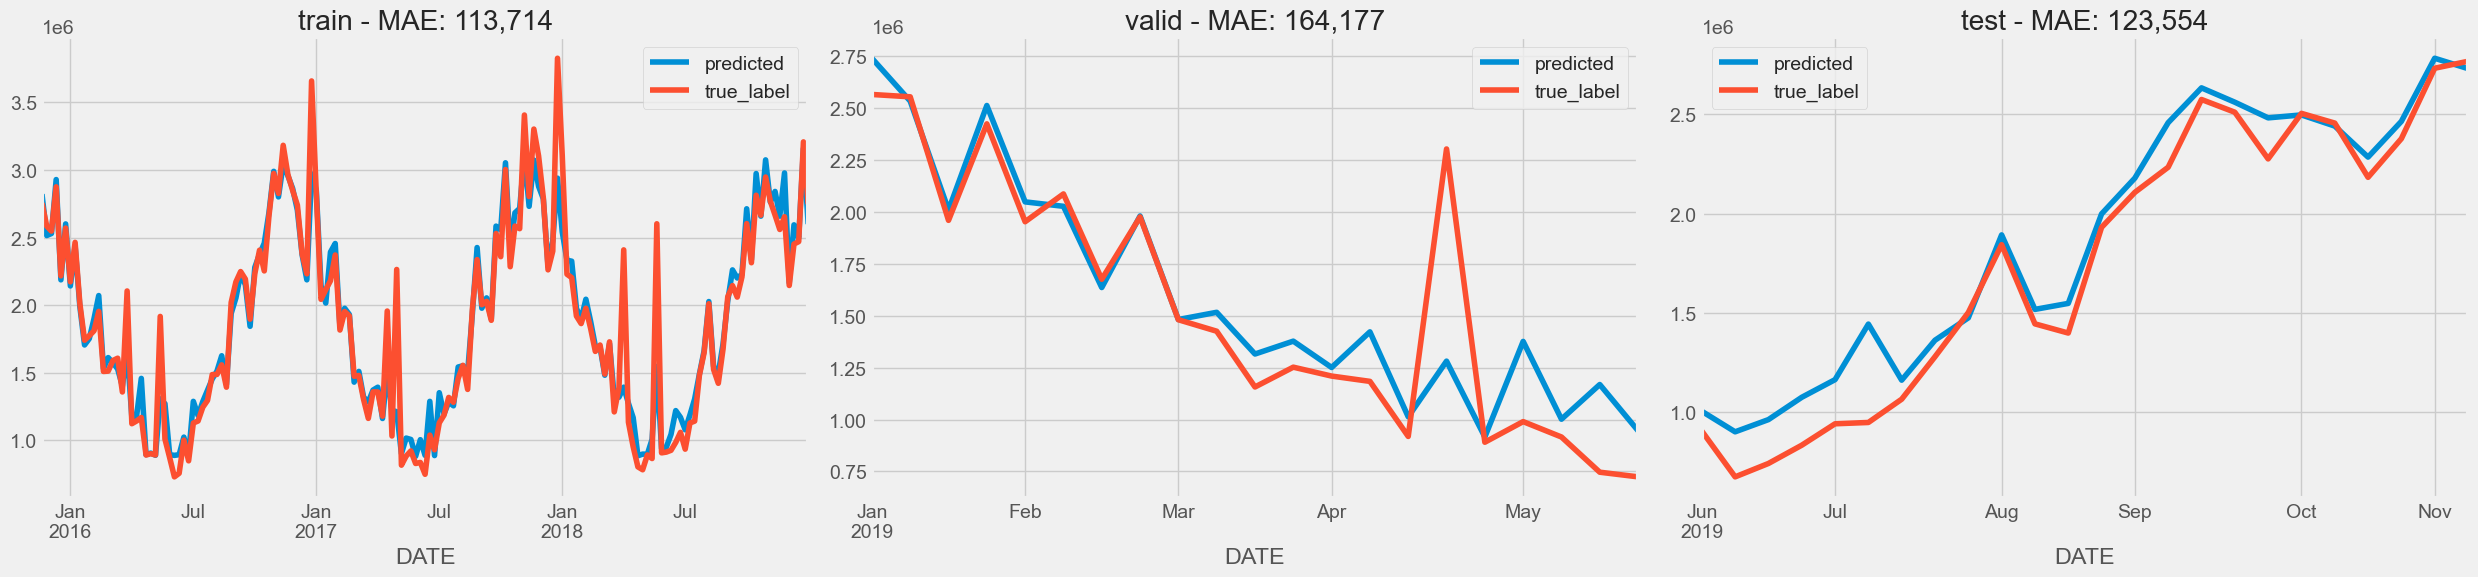

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

data = 'test'
rmse_metric = mean_squared_error(y_true=result[data]["true_label"], y_pred=result[data]["predicted"], squared=False)
mape_metric = mean_absolute_percentage_error(y_true=result[data]["true_label"], y_pred=result[data]["predicted"])
r2_metric = r2_score(y_true=result[data]["true_label"], y_pred=result[data]["predicted"])

print(f'RMSE: {rmse_metric}')
print(f'MAPE: {mape_metric}')
print(f'R2: {r2_metric}')


fig, ax = plt.subplots(figsize = (25, 8))
ax.plot(result[data]["predicted"], color="blue", label="predicted")
ax.plot(result[data]["true_label"], 'ro', label="true")
plt.title(f"RMSE: {np.round(rmse_metric)}, MAPE: {np.round(mape_metric, 3)}, R2: {np.round(r2_metric,3)}")
ax.legend()

invalid value encountered in divide


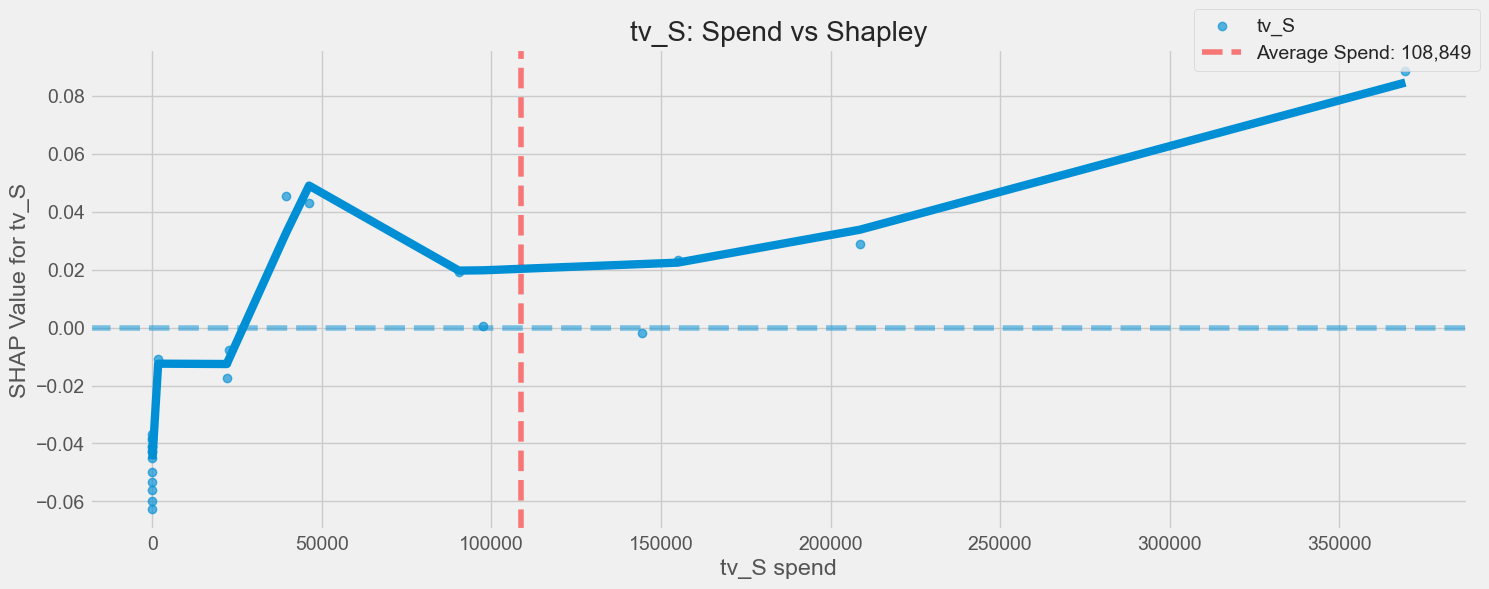

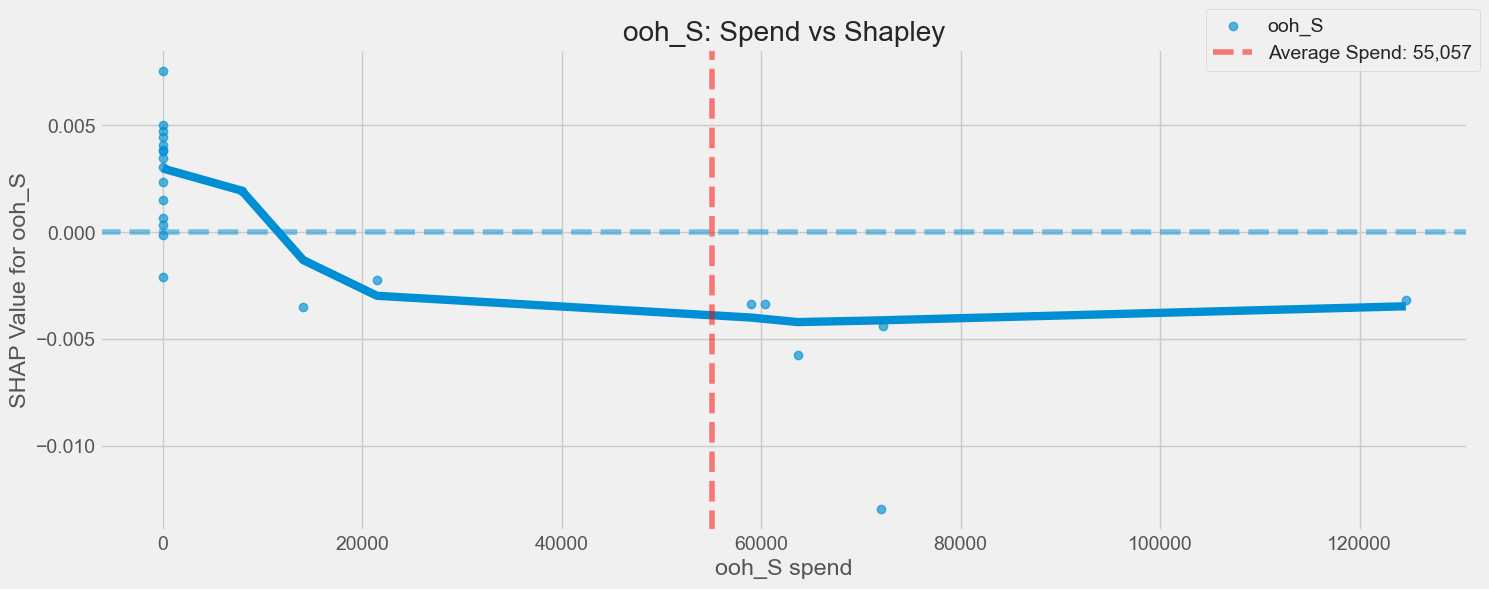

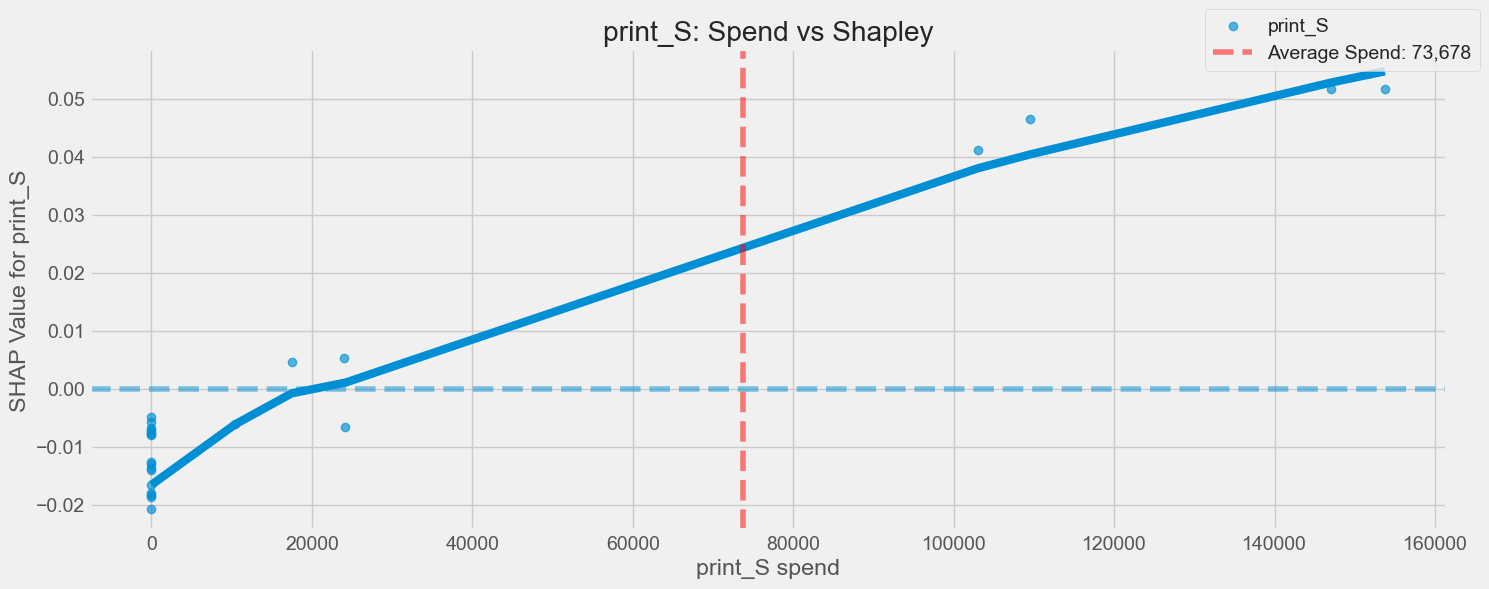

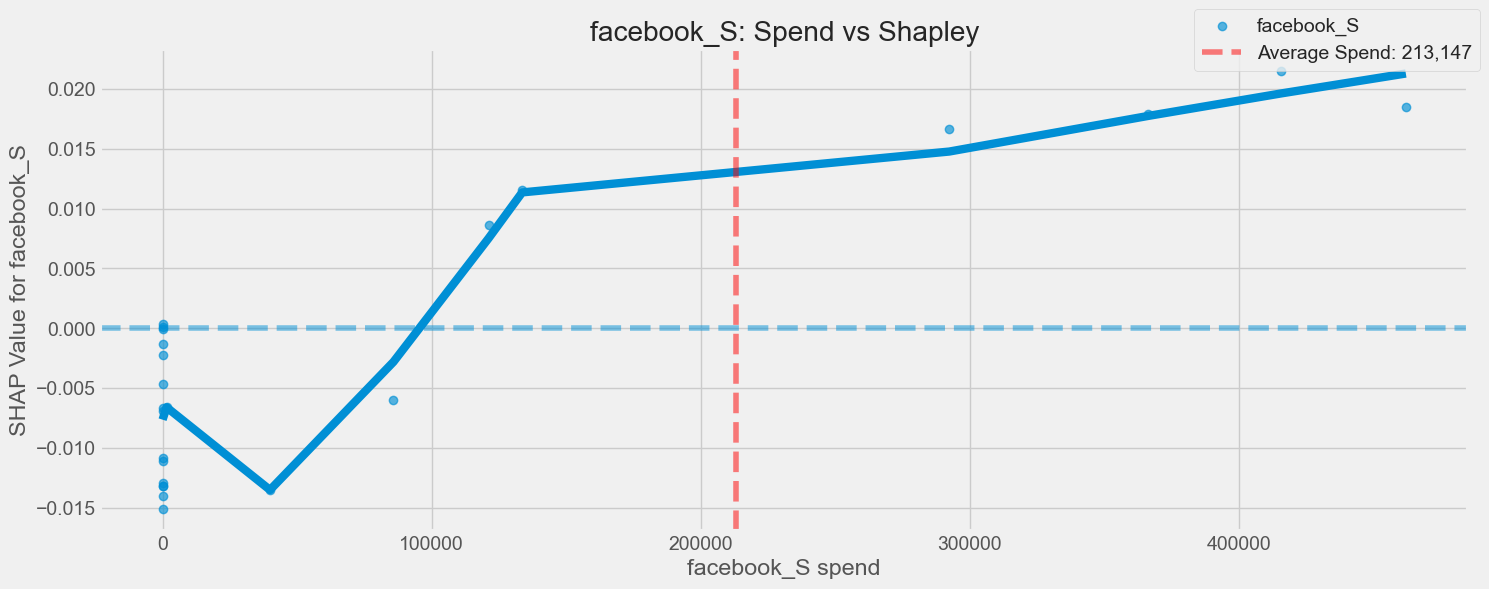

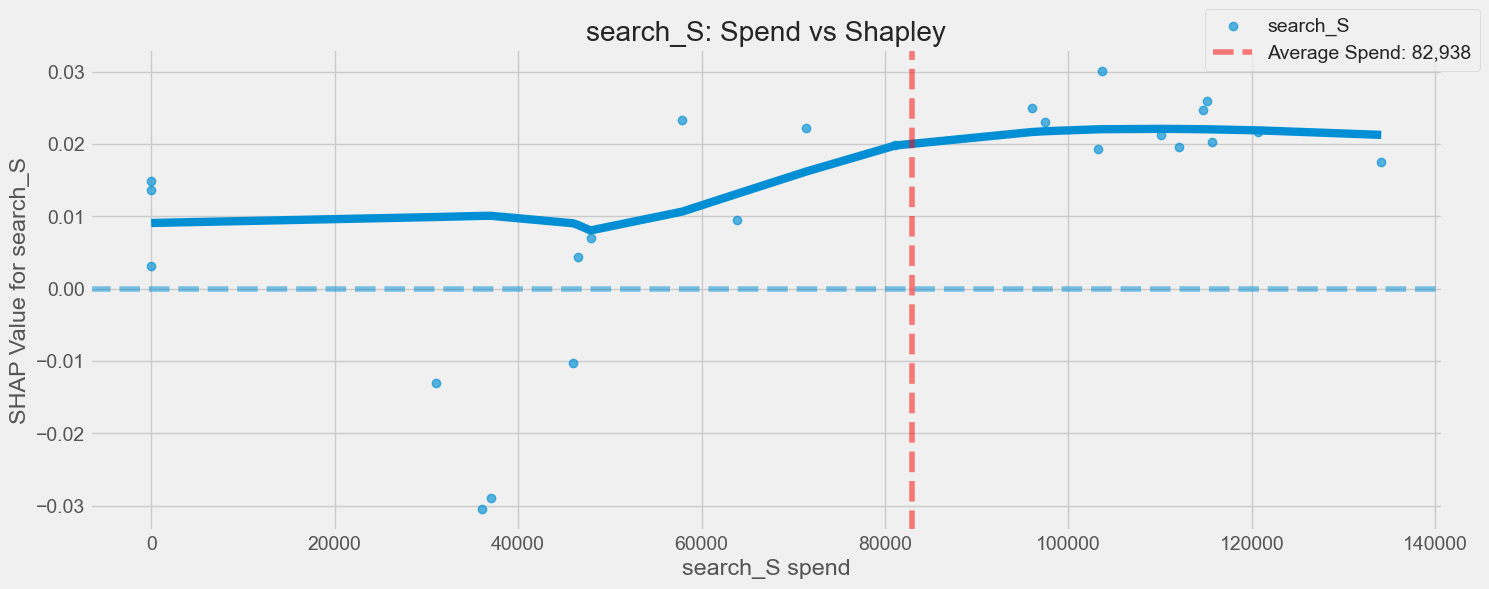

In [7]:
spend_effect_share

In [ ]:
spend_effect_share.query(f'test_set_channels == {media_channels}').set_index('test_set_channels').plot(kind='barh')

In [ ]:
sns.barplot(data=spend_effect_share, x='test_set_channels', )

In [ ]:
def optuna_trial(trial, data, media_features, adstock_features_params,
                 is_multiobjective: bool = False):
    # Clone
    data_tmp = data.copy()

    # Ad
    adstock_alphas = {}
    for feature, val in adstock_features_params.items():
        # Adstock
        min_, max_ = val
        adstock_alpha = trial.suggest_uniform(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha
        # Fit
        x_feature = data_tmp[feature].values.reshape(-1, 1)
        data_tmp[feature] = AdstockGeometric(alpha=adstock_alpha).fit_transform(x_feature)

    # Model:Split
    train = Training(all_features, label_name, data_tmp)
    X, y, dataset = train.train_split('2019-01-01', '2019-06-01')

    params = {
        'objective': ['poisson', 'gamma'],
        'metric': ['mae', 'mape', 'rmse'],
        'random_state': 42,
        'verbose': -1,
        'n_estimators': trial.suggest_int("n_estimators", 100, 8000),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    scores = []
    rssds = []
    model = LGBMRegressor(**params)
    model.fit(X['train'], y['train'], eval_set=[(X['valid'], y['valid'])])
    pred = model.predict(X['test'])
    rmse = mean_squared_error(y_true=y['test'], y_pred=pred, squared=False)
    scores.append(rmse)

    if is_multiobjective:
        explainer = shap.TreeExplainer(model)
        df_shap = pd.DataFrame(explainer.shap_values(X['test']), columns=media_features)
        spend_effect_share = train.shap_effects(df_shap, media_features)
        decomp_rssd = train.rssd(spend_effect_share['contribution'].values,
                                 spend_effect_share['distribution'].values)
        rssds.append(decomp_rssd)

    trial.set_user_attr('scores', scores)
    trial.set_user_attr('params', params)
    trial.set_user_attr('adstock_alphas', adstock_alphas)
    trial.set_user_attr('rssds', rssds)

    if not is_multiobjective:
        return np.mean(scores)
    return np.mean(scores), np.mean(rssds)


def optuna_optimize(data, adstock_features, adstock_features_params, media_features,
                    n_trials: int = 2000, multi_objective: bool = False, seed: int = 42):
    print(f'data size: {len(data)}')
    print(f'media features: {media_features}')
    print(f'adstock features: {adstock_features}')
    print(f'is_multiobjective: {multi_objective}')

    if not multi_objective:
        study_mmm = opt.create_study(direction='minimize', sampler=opt.samplers.TPESampler(seed=seed))
    else:
        study_mmm = opt.create_study(directions=['minimize', 'minimize'],
                                     sampler=opt.samplers.NSGAIISampler(seed=seed))
    optimization_function = partial(optuna_trial,
                                    data=data,
                                    adstock_features=adstock_features,
                                    adstock_features_params=adstock_features_params,
                                    media_features=media_features,
                                    is_multiobjective=multi_objective)
    study_mmm.optimize(optimization_function, n_trials=n_trials, show_progress_bar=True)

    return study_mmm

In [ ]:
organic_channels = ['newsletter']
media_channels = ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
features = ['competitor_sales_B', 'events'] + media_channels + organic_channels
target = 'revenue'
adstock_features = media_channels + organic_channels
adstock_features_params = {
    'tv_S_adstock': (0.3, 0.8),
    'ooh_S_adstock': (0.1, 0.4),
    'print_S_adstock': (0.1, 0.4),
    'facebook_S_adstock': (0.0, 0.4),
    'search_S_adstock': (0.0, 0.3),
    'newsletter_adstock': (0.1, 0.4),
}

experiment = optuna_optimize(trials=2000,
                             data=df,
                             target=target,
                             features=features,
                             adstock_features=media_channels + organic_channels,
                             adstock_features_params=adstock_features_params,
                             media_features=media_channels,
                             multi_objective=False)